# Определение возраста покупателей

## Исследовательский анализ данных

In [1]:
# < Перенесите сюда исследовательский анализ данных >

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import accuracy_score

In [3]:
labels = pd.read_csv('/datasets/faces/labels.csv')
datagen = ImageDataGenerator(rescale=1./255)
gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [4]:
def info(df, flow):
    print('первые пять строк датасета:')
    display(df.head())
    print('')
    print('Размер выборки:')
    display(df.shape)
    print('')
    print('Информация о датасете:')
    df.info()
    print('')
    print('Статистика:')
    display(df.describe())
    print('')
    plt.figure(figsize=(12, 12))
    sns.histplot(labels['real_age'], bins=100)
    plt.title('График распределения возраста в выборке:', fontsize=20)
    plt.xlabel('Возраст людей на изображенных на фотографии', fontsize=15)
    plt.ylabel('Количество людей соответствующего возраста', fontsize=15)
    plt.show()
    print('Фотографии в выборке:')
    features, target = next(gen_flow)
    fig = plt.figure(figsize=(10,10))
    for i in range(16):
        fig.add_subplot(4, 4, i+1)
        plt.imshow(features[i])
        plt.title(df.iloc[i]['file_name'])
        plt.xticks([])
        plt.yticks([])
        plt.tight_layout()

первые пять строк датасета:


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17



Размер выборки:


(7591, 2)


Информация о датасете:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB

Статистика:


,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


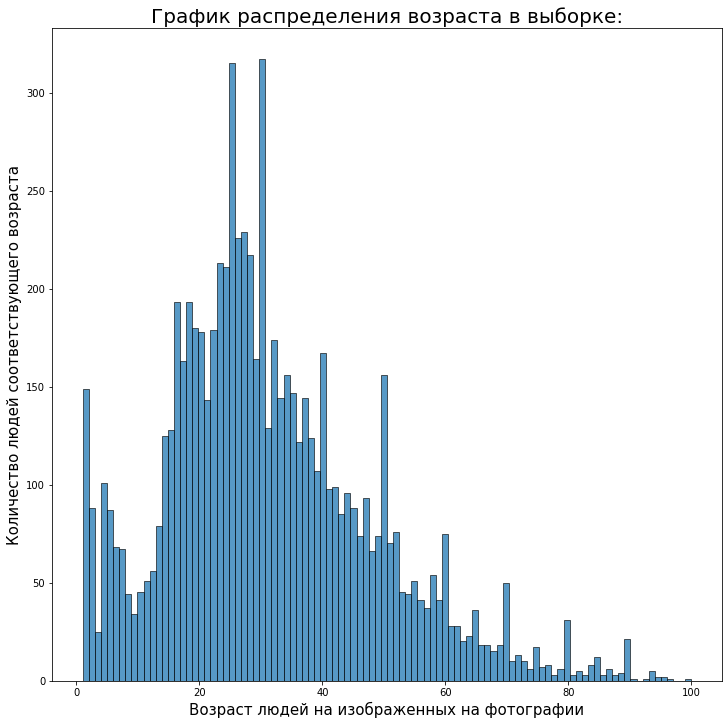

Фотографии в выборке:


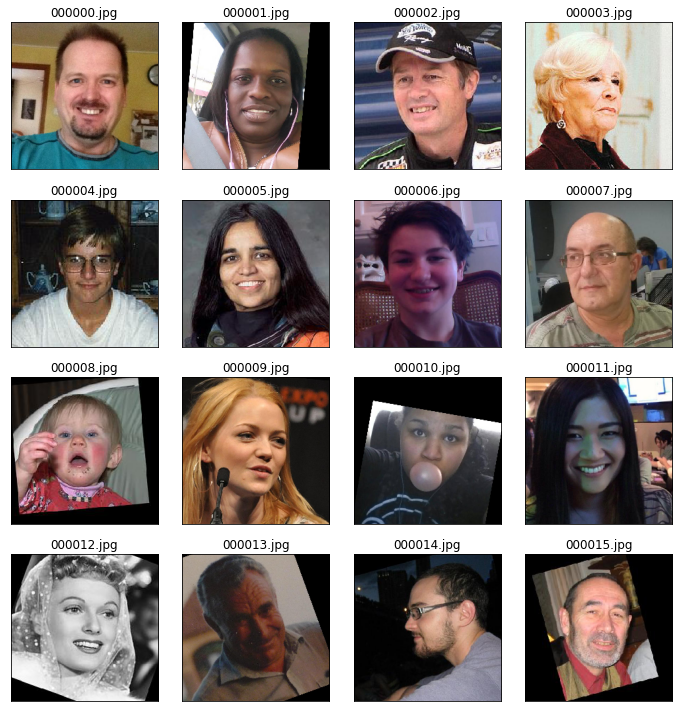

In [5]:
info(labels, gen_flow)

**Вывод:**
Датасет представляет из себя пары, имя изображения и возраст человека изображенного на фото. Состоит из 7591 строки и двух столбцов. <br>
Столбец `file_name` имеет тип object, содержит наименование изображения, которое состоит из цифр и латинских строчных символов, обозначающих формат сжатия .jpg.<br>
Столбец `real_age` содержит возрат челевека изображенного на фотографии. Тип данных int.<br>
Минимальное значение возраста людей 1год, максимальное значение 100 лет. Средний возраст людей 31,2 год, медианный возраст 29 лет.

В датасете представленны:
- фотографии людей разного пола, возраста и национальности;
- фотографии сделаны в разные года;
- изображения цветные и чернобелые различного качества;
- некоторые изображения повернуты на различный угол как по часовой, так и против часовой стрелке;
- некоторые изображения обрезаны, имеют дефекты, размытие и другие помехи.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from tensorflow.keras.applications.resnet import ResNet50
from sklearn.metrics import mean_absolute_error

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255, 
                                       validation_split=0.2,
                                       width_shift_range=0.2, 
                                       height_shift_range =0.2,
                                       horizontal_flip=True)

    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_datagen_flow
    
def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
    return test_datagen_flow

def create_model(input_shape):
    optimizer = Adam(lr = 0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet', 
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    return model
    
def train_model(model, train_data, test_data, batch_size=None, epochs=10, steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2,
              shuffle=True)
    return model

```

```

Epoch 1/10
    to  
Train for 190 steps, validate for 48 steps
  ...
  ['...']
2023-03-03 07:09:17.379639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-03 07:09:19.419228: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
190/190 - 119s - loss: 265.2436 - mae: 11.5745 - val_loss: 591.9574 - val_mae: 19.1970
Epoch 2/10
190/190 - 92s - loss: 94.0674 - mae: 7.2885 - val_loss: 567.3697 - val_mae: 18.6640
Epoch 3/10
190/190 - 92s - loss: 74.3390 - mae: 6.5178 - val_loss: 234.1445 - val_mae: 11.2112
Epoch 4/10
190/190 - 92s - loss: 59.2987 - mae: 5.8518 - val_loss: 115.8368 - val_mae: 8.1827
Epoch 5/10
190/190 - 92s - loss: 51.0899 - mae: 5.4658 - val_loss: 78.5075 - val_mae: 6.4894
Epoch 6/10
190/190 - 92s - loss: 42.7292 - mae: 5.0311 - val_loss: 72.2423 - val_mae: 6.1958
Epoch 7/10
190/190 - 94s - loss: 37.7045 - mae: 4.7159 - val_loss: 71.5873 - val_mae: 6.2938
Epoch 8/10
190/190 - 92s - loss: 32.7039 - mae: 4.4196 - val_loss: 81.3559 - val_mae: 6.4938
Epoch 9/10
190/190 - 92s - loss: 29.9588 - mae: 4.2359 - val_loss: 128.6533 - val_mae: 8.5988
Epoch 10/10
190/190 - 92s - loss: 29.5745 - mae: 4.1959 - val_loss: 82.3880 - val_mae: 6.8593
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
48/48 - 8s - loss: 82.3880 - mae: 6.8593
Test MAE: 6.8593

```

## Анализ обученной модели

В соответствии с поставленой задачей, создал нейронную сеть с архитектурой ResNet50 предобученную на ImageNet. Обучение модели проходило на 10 эпохах с применением алгоритма Adam, со скоростью обучения learning_rate = 0.0001.<br>
Лудшее значение средней обсолютной ошибки MAE (Mean Ablosute Error), на обучающей выборке равно 6.19. На тестовой выборке достигнуто значение 6.86. <br>
По сути это ошибка определения возраста в годах, то есть наша модель определяет возраст человека с точностью +/- ~7 лет. <br>
Такая модель подходит для того чтобы предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, но такая модель не может точно определить достиг ли покупатель возраста для покупку алкоголя и табачной продукции.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> дополнительные материалы </b>
В курсе уже есть ссылки на отдельные статьи. Со своей стороны поделюсь неплохими бесплатными курсами по нейронкам, дающим целостную картинку.
    
   - "Дип Лернинг на пальцах" (https://www.youtube.com/playlist?list=PL5FkQ0AF9O_o2Eb5Qn8pwCDg7TniyV1Wb).
   - Отличный бесплатный курс от Школы глубокого обучения МФТИ (https://stepik.org/org/dlschool), старт курса каждые пол года. Два семестра, один по основам и компьютерному зрению, второй по обработке естественного языка.
   - "Нейронные сети и компьютерное зрение" от Samsung Research Russia (https://stepik.org/course/50352/syllabus). Есть также продолжение по NLP.  

</div>